# 利用 BERT 模型解析电子病历
## 项目原始地址
[项目地址](https://github.com/kexinhuang12345/clinicalBERT)
本项目改编自此 Github 项目，鸣谢作者。

## 问题描述
我们希望能从患者住院期间的临床记录来预测该患者未来30天内是否会再次入院，该预测可以辅助医生更好的选择治疗方案并对手术风险进行评估。在临床中治疗手段常见而预后情况难以控制管理的情况屡见不鲜。比如关节置换手术作为治疗老年骨性关节炎等疾病的最终方法在临床中取得了极大成功，但是与手术相关的并发症以及由此导致的再入院情况也并不少见。患者的自身因素如心脏病、糖尿病、肥胖等情况也会增加关节置换术后的再入院风险。当接受关节置换手术的人群的年龄越来越大，健康状况越来越差的情况下，会出现更多的并发症并且增加再次入院风险。
通过电子病历的相关记录，观察到对于某些疾病或者手术来说，30天内再次入院的患者各方面的风险都明显增加。因此对与前次住院原因相同，且前次出院与下次入院间隔未超过30天的再一次住院视为同一次住院的情况进行了筛选标注，训练模型来尝试解决这个问题。

## 数据选取与数据清洗
选取于 Medical Information Mart for Intensive Care III 数据集，也称 MIMIC-III，是在NIH资助下，由MIT、哈佛医学院BID医学中心、飞利浦医疗联合开发维护的多参数重症监护数据库。该数据集免费向研究人员开放，但是需要进行申请。申请流程请参见[这个链接](https://www.kesci.com/home/project/share/d3c99274f9d328a8)。我们在进行实验的时候将数据部署在 Postgre SQL 中。首先从admission表中取出所有数据，针对每一条记录计算同个subject_id下一次出现时的时间间隔，若小于30天则给该条记录添加标签Label=1，否则Label=0。然后再计算该次住院的时长（出院日期-入院日期），并抽取其中住院时长>2的样本。将上述抽出的所有样本的HADM_ID按照0.8:0.1:0.1的比例随机分配形成训练集、验证集和测试集。之后再从noteevents表中按照之前分配好的HADM_ID获取各个数据集的文本内容（即表noteevents中的TEXT列）。整理好的训练集、验证集和测试集均含有三列，分别为TEXT（文本内容），ID（即HADM_ID），Label（0或1），这里我们提供一份清洗完成的测试数据供大家使用（仅提供其中一部分）。测试数据已以数据集的形式公开在和鲸社区，查看详情请点击[这里](https://www.kesci.com/home/dataset/5f5b287362e92d003b21b6c5/files)。

## 预训练模型
原项目使用的预训练模型。基于 BERT 训练。在NLP（自然语言处理）领域BERT模型有着里程碑式的意义。2018年的10月11日，Google发布的论文《Pre-training of Deep Bidirectional Transformers for Language Understanding》，成功在 11 项 NLP 任务中取得 state of the art 的结果，赢得自然语言处理学界的一片赞誉之声。BERT模型在文本分类、文本预测等多个领域都取得了很好的效果。
更多关于BERT模型的内容可参考[链接](https://arxiv.org/abs/1810.04805)  
  

BERT算法的原理主要由两部分组成：
* 第一步，通过对大量未标注的语料进行非监督的预训练，来学习其中的表达法。
* 其次，使用少量标记的训练数据以监督方式微调（fine tuning）预训练模型以进行各种监督任务。  

ClinicalBERT 模型根据含有标记的临床记录对BERT模型进行微调，从而得到一个可以用于医疗领域文本分析的模型。细节请参考原项目链接

## 环境安装

In [39]:
!pip install -U pytorch-pretrained-bert -i https://pypi.tuna.tsinghua.edu.cn/simple
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: pytorch-pretrained-bert in /opt/conda/lib/python3.7/site-packages (0.6.2)


## 数据查看
让我们来看看被预测的数据是什么格式

In [40]:
import pandas as pd
sample = pd.read_csv('/home/kesci/input/MIMIC_note3519/BERT/sample.csv')
sample

,TEXT,ID,Label
0,Nursing Progress Note 1900-0700 hours:\n** Ful...,176088,1
1,Nursing Progress Note 1900-0700 hours:\n** Ful...,135568,1
2,"NPN:\n\nNeuro: Alert and oriented X2-3, Sleepi...",188180,0
3,RESPIRATORY CARE:\n\n35 yo m adm from osh for ...,110655,0
4,"NEURO: A+OX3 pleasant, mae, following commands...",139362,0
5,Nursing Note\nSee Flowsheet\n\nNeuro: Propofol...,176981,0


可以看到在 TEXT 字段下存放了几条非结构的文本数据，让我们来取出一条看看在说什么。

In [41]:
text = sample['TEXT'][0]
print(text)

Nursing Progress Note 1900-0700 hours:
** Full code

** allergy: nkda

** access: #18 piv to right FA, #18 piv to right FA.

** diagnosis: angioedema

In Brief: Pt is a 51yo F with pmh significant for: COPD, HTN, diabetes insipidus, hypothyroidism, OSA (on bipap at home), restrictive lung disease, pulm artery hypertension attributed to COPD/OSA, ASD with shunt, down syndrome, CHF with LVEF >60%. Also, 45pk-yr smoker (quit in [**2112**]).

Pt brought to [**Hospital1 2**] by EMS after family found with decreased LOC.  Pt presented with facial swelling and mental status changes. In [**Name (NI) **], pt with enlarged lips and with sats 99% on 2-4l.  Her pupils were pinpoint so given narcan.  She c/o LLQ abd pain and also developed a severe HA.  ABG with profound resp acidosis 7.18/108/71.  Given benadryl, nebs, solumedrol. Difficult intubation-req'd being taken to OR to have fiberoptic used.  Also found to have ARF.  On admit to ICU-denied pain in abdomen, denied HA.  Denied any pain. Pt u

### 文本内容
可以看到是一段 ICU 的护理日记，是一个 51 岁的女性，有慢性阻塞性肺疾病，高血压，甲减，唐氏综合征，先心房缺，慢性心衰，肺动脉高压，睡眠呼吸暂停综合症等多种疾病。被家人发现昏迷后送医，是严重的过敏反应，急性血管水肿。处于镇静状态有轻微意识。她在治疗过的过程中发生过好凝，做过溶拴还发生过急性肾衰竭。

## 模型推理

### 修改当前工作路径

In [42]:
import os
os.chdir('/home/kesci/work/clinicalBERT')

### 基础类定义
每个类的说明见注释

In [43]:
import csv
import pandas as pd


class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""
    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file = pd.read_csv(input_file)
        lines = zip(file.ID, file.TEXT, file.Label)
        return lines

### 定义数据读取与处理类
继承自基类

In [44]:
def create_examples(lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
        guid = "%s-%s" % (set_type, i)
        text_a = line[1]
        label = str(int(line[2]))
        examples.append(
            InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples


class ReadmissionProcessor(DataProcessor):
    def get_test_examples(self, data_dir):
        return create_examples(
            self._read_csv(os.path.join(data_dir, "sample.csv")), "test")

    def get_labels(self):
        return ["0", "1"]

### 定义脚手架函数
- `truncate_seq_pair`
- `convert_examples_to_features`
- `vote_score`
- `pr_curve_plot`
- `vote_pr_curve`

In [45]:
# 将语料对按最大长度截取语料
def truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [46]:
# 将文件载入，并且转换为张量
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [47]:
# 准确率曲线与绘图
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def vote_score(df, score, ax):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    return fpr, tpr, df_out

In [48]:
from sklearn.metrics import precision_recall_curve
from funcsigs import signature


def pr_curve_plot(y, y_score, ax):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall, precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    ax.step(recall, precision, color='b', alpha=0.2,
             where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall curve: AUC={0:0.2f}'.format(
        area))

In [49]:
def vote_pr_curve(df, score, ax):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    # score
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max) + df_sort.groupby(['ID'])['pred_score'].agg(sum) / 2) / (
                1 + df_sort.groupby(['ID'])['pred_score'].agg(len) / 2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values

    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data=list(zip(precision, recall, thres)), columns=['prec', 'recall', 'thres'])

    pr_curve_plot(y, temp, ax)

    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()

    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print(f'Recall at Precision of 80 is {rp80}')

    return rp80

### 配置推理参数
- `output_dir`: 输出文件的目录 
- `task_name`:  任务名称
- `bert_model`:  模型目录
- `data_dir`:  数据目录，默认文件名称为 sample.csv
- `max_seq_length`:  最大字符串序列长度
- `eval_batch_size`:  推理批的大小，越大占内存越大

In [50]:
config = {
    "local_rank": -1,
    "no_cuda": False,
    "seed": 42,
    "output_dir": './result',
    "task_name": 'readmission',
    "bert_model": '/home/kesci/input/MIMIC_note3519/BERT/early_readmission',
    "fp16": False,
    "data_dir": '/home/kesci/input/MIMIC_note3519/BERT',
    "max_seq_length": 512,
    "eval_batch_size": 2,
}

### 执行推理
推理过程会产生大量日志，可以通过选择当前 cell （选择后cell左侧会变为蓝色），按下键盘上的 “O” 键来隐藏日志输出

In [51]:
import random
from tqdm import tqdm
from pytorch_pretrained_bert.tokenization import BertTokenizer
from modeling_readmission import BertForSequenceClassification
from torch.utils.data import TensorDataset, SequentialSampler, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch


processors = {
    "readmission": ReadmissionProcessor
}

if config['local_rank'] == -1 or config['no_cuda']:
    device = torch.device("cuda" if torch.cuda.is_available() and not config['no_cuda'] else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", config['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device %s n_gpu %d distributed training %r", device, n_gpu, bool(config['local_rank'] != -1))


random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
if n_gpu > 0:
    torch.cuda.manual_seed_all(config['seed'])


if os.path.exists(config['output_dir']):
    pass
else:
    os.makedirs(config['output_dir'], exist_ok=True)

task_name = config['task_name'].lower()

if task_name not in processors:
    raise ValueError(f"Task not found: {task_name}")

processor = processors[task_name]()
label_list = processor.get_labels()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare model
model = BertForSequenceClassification.from_pretrained(config['bert_model'], 1)
if config['fp16']:
    model.half()
model.to(device)
if config['local_rank'] != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config['local_rank']],
                                                      output_device=config['local_rank'])
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

eval_examples = processor.get_test_examples(config['data_dir'])
eval_features = convert_examples_to_features(
    eval_examples, label_list, config['max_seq_length'], tokenizer)
logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", config['eval_batch_size'])
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
if config['local_rank'] == -1:
    eval_sampler = SequentialSampler(eval_data)
else:
    eval_sampler = DistributedSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=config['eval_batch_size'])
model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
true_labels = []
pred_labels = []
logits_history = []
m = torch.nn.Sigmoid()
for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)
    with torch.no_grad():
        tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    logits = torch.squeeze(m(logits)).detach().cpu().numpy()
    label_ids = label_ids.to('cpu').numpy()

    outputs = np.asarray([1 if i else 0 for i in (logits.flatten() >= 0.5)])
    tmp_eval_accuracy = np.sum(outputs == label_ids)

    true_labels = true_labels + label_ids.flatten().tolist()
    pred_labels = pred_labels + outputs.flatten().tolist()
    logits_history = logits_history + logits.flatten().tolist()

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

11/03/2020 10:25:57 - INFO - pytorch_pretrained_bert.modeling -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
11/03/2020 10:25:57 - INFO - __main__ -   device cpu n_gpu 0 distributed training False


in the modeling class


11/03/2020 10:25:58 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpj_xd7wnf
100%|██████████| 231508/231508 [00:01<00:00, 125465.20B/s]
11/03/2020 10:26:01 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpj_xd7wnf to cache at /home/kesci/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/03/2020 10:26:01 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /home/kesci/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
11/03/2020 10:26:01 - INFO - pytorch_pretrained_bert.file_utils -   removing temp file /tmp/tmpj_xd7wnf
11/03/2020 10:26:01 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

11/03/2020 10:26:04 - INFO - __main__ -   *** Example ***
11/03/2020 10:26:04 - INFO - __main__ -   guid: test-0
11/03/2020 10:26:04 - INFO - __main__ -   tokens: [CLS] nursing progress note 1900 - 07 ##00 hours : * * full code * * all ##ergy : nk ##da * * access : # 18 pi ##v to right fa , # 18 pi ##v to right fa . * * diagnosis : ang ##io ##ede ##ma in brief : pt is a 51 ##yo f with pm ##h significant for : cop ##d , h ##t ##n , diabetes ins ##ip ##id ##us , h ##yp ##oth ##yr ##oid ##ism , os ##a ( on bi ##pa ##p at home ) , restrictive lung disease , pu ##lm artery hyper ##tension attributed to cop ##d / os ##a , as ##d with shu ##nt , down syndrome , ch ##f with l ##ve ##f > 60 % . also , 45 ##p ##k - y ##r smoke ##r ( quit in [ * * 211 ##2 * * ] ) . pt brought to [ * * hospital ##1 2 * * ] by ems after family found with decreased lo ##c . pt presented with facial swelling and mental status changes . in [ * * name ( ni ) * * ] , pt with enlarged lips and with sat ##s 99 % on 2 - 4 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

100%|██████████| 3/3 [00:10<00:00,  3.51s/it]


### 绘制精度评价曲线

Recall at Precision of 80 is 0.5


<Figure size 432x288 with 2 Axes>
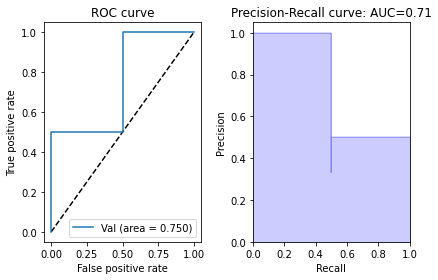

In [52]:
df = pd.DataFrame({'logits': logits_history, 'pred_label': pred_labels, 'label': true_labels})
df_test = pd.read_csv(os.path.join(config['data_dir'], "sample.csv"))

fig = plt.figure(1)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fpr, tpr, df_out = vote_score(df_test, logits_history, ax1)
rp80 = vote_pr_curve(df_test, logits_history, ax2)

output_eval_file = os.path.join(config['output_dir'], "eval_results.txt")
plt.tight_layout()
plt.show()

### 将推理信息保存至输出目录

In [53]:
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples
result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'RP80': rp80}
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

11/03/2020 10:26:15 - INFO - __main__ -   ***** Eval results *****
11/03/2020 10:26:15 - INFO - __main__ -     RP80 = 0.5


11

11/03/2020 10:26:15 - INFO - __main__ -     eval_accuracy = 0.8333333333333334


35

11/03/2020 10:26:15 - INFO - __main__ -     eval_loss = 0.5382882455984751


31

## 小结
通过 ICU 的医疗日记，可以知道患者的丰富的体征、病史等信息。通过这个模型可以有效预测该患者是否还会住院。